In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
from tqdm import tqdm
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
#import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv('train.csv')

In [5]:
data.columns

Index(['datetime', 'Номер скважины', 'Дебит нефти', 'Давление забойное', 'x',
       'y', 'Объем жидкости', 'Объем нефти', 'Активная мощность (ТМ)',
       'Время работы (ТМ)', 'Газовый фактор рабочий (ТМ)', 'Давление буферное',
       'Давление забойное от Hд', 'Давление забойное от Pпр',
       'Давление линейное (ТМ)', 'Давление на входе ЭЦН (ТМ)',
       'Дебит газа (ТМ)', 'Дебит газа попутного', 'Дебит жидкости (ТМ)',
       'Коэффициент мощности (ТМ)'],
      dtype='object')

In [6]:
def lag(dataset, code_column, lag):
    df = np.zeros_like(dataset[code_column].values)
    df[lag:] = dataset[code_column].values[:-lag]
    
    return df   


def data_preprocessing(well_n):
    df = pd.DataFrame()
    datasets = []
    for i in range(1,91):
        well_n1 = well_n.iloc[1:,:].copy()

        well_n1['Дебит нефти_t'] =  well_n1['Дебит нефти'].shift(i)
        #(well_n1['Дебит нефти'].shift(i))/well_n['Дебит нефти'].iloc[0]
         # well_n['Дебит нефти'].iloc[1:].diff(-i)
        #(well_n1['Дебит нефти'].shift(i))/well_n['Дебит нефти'].iloc[0]
        well_n1['Прогноз_вперед'] = i

        df = pd.concat([df,well_n1])
    df = df.dropna(subset=['Дебит нефти_t'])
    y = df[['datetime','Дебит нефти_t']]
    datetime = df['datetime']
    X = df[['Номер скважины','Давление забойное от Hд', 'Давление линейное (ТМ)', 'Дебит нефти','Прогноз_вперед',
            'Давление забойное','Дебит жидкости (ТМ)','Газовый фактор рабочий (ТМ)',
      'Дебит газа (ТМ)','Давление забойное от Pпр','Давление на входе ЭЦН (ТМ)' ]]
    X = X.interpolate(method = 'linear', axis = 1).ffill().bfill()
    windows = [7,14,30,90] #,180,360]
    i = 0
    cols = X.columns
    cols = cols[cols != 'Прогноз_вперед']
    statistic = ['mean','std'] #'min','max', 'var']
    for win in windows:
        for stat in statistic:
            for f in cols:
                if f =='Прогноз_вперед' or f == 'Номер скважины':
                    continue
                else: 
                    X[f'{f}_window_{win}_stat_{stat}'] = X.rolling(window = win, min_periods=1)[f].agg(stat).ffill().bfill()
                    
    lag_l = ['Дебит нефти', 'Давление забойное','Дебит жидкости (ТМ)','Давление забойное от Hд','Давление линейное (ТМ)', 'Дебит газа (ТМ)']             
    lag1 = pd.DataFrame(lag(X, lag_l,5), columns = ['Lag51','Lag52','Lag53','Lag54','Lag55','Lag56'])
    lag2 = pd.DataFrame(lag(X, lag_l,4), columns =['Lag41','Lag42','Lag43','Lag44','Lag45','Lag46'])
    lag3 = pd.DataFrame(lag(X, lag_l,3), columns = ['Lag31','Lag32','Lag33','Lag34','Lag35','Lag36'])
    lag4 = pd.DataFrame(lag(X, lag_l,2), columns = ['Lag21','Lag22','Lag23','Lag24','Lag25','Lag26'])
    lag5 = pd.DataFrame(lag(X, lag_l,6), columns = ['Lag61','Lag62','Lag63','Lag64','Lag65','Lag66'])
    lag6 = pd.DataFrame(lag(X, lag_l,7), columns = ['Lag71','Lag72','Lag73','Lag74','Lag75','Lag76'])
    lag7 = pd.DataFrame(lag(X, lag_l,8), columns = ['Lag81','Lag82','Lag83','Lag84','Lag85','Lag86'])
    lags = pd.concat([lag1,lag2,lag3,lag4,lag5,lag6,lag7], axis = 1)
    X = pd.concat([X.reset_index(drop=True),lags],axis = 1)
    return X, y,datetime, well_n['Дебит нефти'].iloc[0]
                  
 
    

In [7]:
SAMPLE_RATE = 0.4
RANDOM_SEED = 1
EARLY_STOPPING_ROUND = 10

In [8]:
X,y, datetime,reference = data_preprocessing(data)

In [95]:
X['datetime'] = datetime.reset_index(drop=True)

In [96]:
min_date=pd.to_datetime('1990-10-30'), 
max_date='1992-01-11'
X_train = X.loc[(X.datetime < max_date )]
X_valid = X.loc[(X.datetime > max_date )]
y_valid = y.loc[(y.datetime > max_date )]
y_train = y.loc[(y.datetime < max_date )]

In [97]:
X_train = X_train.drop(columns = 'datetime')
X_valid = X_valid.drop(columns = 'datetime')
y_train = y_train.drop(columns = 'datetime')
y_valid = y_valid.drop(columns = 'datetime')

In [98]:
def train_model(X_train,y_train,X_valid, y_valid):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y.iloc[:,1:], test_size=0.1, random_state=RANDOM_SEED,  stratify = X['Прогноз_вперед'])  #shuffle = False)
    optimized_regressor = CatBoostRegressor(learning_rate=0.1,
                                        depth=15, #study.best_params['depth'],
                                        l2_leaf_reg=5, #study.best_params['l2_leaf_reg'],
                                        min_child_samples= 3, #study.best_params['min_child_samples'],
                                        grow_policy='Depthwise',
                                        iterations=500,
                                        use_best_model=True,
                                        eval_metric='RMSE',
                                        od_type='iter',
                                       # od_wait=20,
                                        
                                        random_state=RANDOM_SEED,
                                      #  logging_level='Silent',
                                      #  task_type="GPU",
                                     verbose = True
                                       )
    optimized_regressor.fit(X_train.copy(), y_train.copy(),
                        eval_set=[(X_valid.copy(), y_valid.copy())],
                        early_stopping_rounds=EARLY_STOPPING_ROUND)
    return optimized_regressor

In [99]:
X = X.drop(columns='datetime')

In [100]:
%%time
#X_train, X_valid, y_train, y_valid = train_test_split(X, y.iloc[:,1:], test_size=0.1, random_state=RANDOM_SEED,  stratify = X['Прогноз_вперед'])  #shuffle = False)
optimized_regressor = CatBoostRegressor(learning_rate=0.1,
                                        depth=9, #study.best_params['depth'],
                                        l2_leaf_reg=15, #study.best_params['l2_leaf_reg'],
                                        min_child_samples= 7, #study.best_params['min_child_samples'],
                                        grow_policy= 'SymmetricTree', #'Depthwise',
                                        iterations=300,
                                        use_best_model=True,
                                        eval_metric='RMSE',
                                        od_type='iter',
                                       # od_wait=20,
                                        
                                        random_state=RANDOM_SEED,
                                      #  logging_level='Silent',
                                      #  task_type="GPU",
                                     verbose = True
                                       )
optimized_regressor.fit(X_train.copy(), y_train.copy(),
                        eval_set=[(X_valid.copy(), y_valid.copy())],
                        early_stopping_rounds=EARLY_STOPPING_ROUND)
pred_train = optimized_regressor.predict(X_train.copy())
pred_valid = optimized_regressor.predict(X_valid.copy())

0:	learn: 8.3642922	test: 6.8653584	best: 6.8653584 (0)	total: 296ms	remaining: 1m 28s
1:	learn: 7.6801766	test: 6.3032545	best: 6.3032545 (1)	total: 574ms	remaining: 1m 25s
2:	learn: 7.0759307	test: 5.8048284	best: 5.8048284 (2)	total: 855ms	remaining: 1m 24s
3:	learn: 6.5261083	test: 5.3250118	best: 5.3250118 (3)	total: 1.13s	remaining: 1m 23s
4:	learn: 6.0520846	test: 4.9377048	best: 4.9377048 (4)	total: 1.41s	remaining: 1m 23s
5:	learn: 5.6368199	test: 4.5860178	best: 4.5860178 (5)	total: 1.69s	remaining: 1m 22s
6:	learn: 5.2596708	test: 4.2712029	best: 4.2712029 (6)	total: 1.97s	remaining: 1m 22s
7:	learn: 4.9447354	test: 4.0253662	best: 4.0253662 (7)	total: 2.24s	remaining: 1m 21s
8:	learn: 4.6702020	test: 3.7933458	best: 3.7933458 (8)	total: 2.52s	remaining: 1m 21s
9:	learn: 4.4329508	test: 3.5916163	best: 3.5916163 (9)	total: 2.79s	remaining: 1m 20s
10:	learn: 4.2137159	test: 3.4082074	best: 3.4082074 (10)	total: 3.07s	remaining: 1m 20s
11:	learn: 4.0377452	test: 3.2558493	best

# Test model

In [132]:
well = 48

In [133]:
wells = data['Номер скважины'].unique()
well_n = data.query(f'`Номер скважины` == {wells[well]}')


In [134]:
max_date='1992-01-11'
X['datetime'] = datetime.values
last_date = well_n[well_n.datetime == max_date]  
last_date_pred = X.loc[(X.datetime == max_date) & (X['Номер скважины'] == well)]
last_date_pred_f = last_date_pred.drop(columns='datetime').iloc[0]

In [135]:
last_date_pred = X.loc[(X.datetime < last_date.datetime.values[0]) & (X['Номер скважины'] == well)]

In [136]:
last_date_pred

,Номер скважины,Давление забойное от Hд,Давление линейное (ТМ),Дебит нефти,Прогноз_вперед,Давление забойное,Дебит жидкости (ТМ),Газовый фактор рабочий (ТМ),Дебит газа (ТМ),Давление забойное от Pпр,...,Lag74,Lag75,Lag76,Lag81,Lag82,Lag83,Lag84,Lag85,Lag86,datetime
30550,48.0,32.991667,17.983333,2.975,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,31.895664,13.979756,92.280000,0.902,31.895664,77.845998,31.895664,14.445932,169.746667,1990-08-01
30551,48.0,83.820812,1.644479,2.975,1.0,83.820812,82.639969,81.459126,80.278283,79.097440,...,31.757069,13.595061,192.503333,1.184,31.895664,4.450000,31.895664,13.979756,92.280000,1990-08-02
30552,48.0,83.669934,1.619767,3.587,1.0,83.669934,21.700000,56.835000,91.970000,79.097491,...,31.852716,14.559210,14.801658,0.745,31.757069,2.800000,31.757069,13.595061,192.503333,1990-08-03
30553,48.0,83.611113,1.606990,3.735,1.0,83.611113,22.600000,25.996667,29.393333,79.097503,...,31.898375,14.796351,100.736667,0.604,31.852716,3.023333,31.852716,14.559210,14.801658,1990-08-04
30554,48.0,83.609387,1.595520,3.752,1.0,83.609387,22.700000,56.970000,91.240000,79.097505,...,30.642125,14.284249,87.955000,0.754,31.898375,3.000000,31.898375,14.796351,100.736667,1990-08-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6001994,48.0,83.537286,16.266440,4.064,90.0,83.537286,12.800000,12.800000,12.800000,12.800000,...,83.395653,16.597607,129.795000,4.085,83.538495,16.233333,83.538495,16.364463,70.256667,1992-01-06
6001995,48.0,83.537286,16.396775,4.033,90.0,83.537286,16.400000,16.400000,16.400000,16.400000,...,83.468993,17.139937,176.925000,4.556,83.395653,18.100000,83.395653,16.597607,129.795000,1992-01-07
6001996,48.0,83.322850,16.285909,4.002,90.0,83.322850,15.900000,15.900000,15.900000,15.900000,...,83.388744,17.321666,11.083333,4.304,83.468993,17.100000,83.468993,17.139937,176.925000,1992-01-08
6001997,48.0,83.404459,16.669574,3.708,90.0,83.404459,14.733333,14.733333,14.733333,14.733333,...,83.600797,16.960450,24.040000,4.614,83.388744,18.333333,83.388744,17.321666,11.083333,1992-01-09


In [105]:
rmse_cum = 0
rmse_cum_const = 0
for well in wells:
    X['datetime'] = datetime.values

    last_date = well_n[well_n.datetime == max_date]       
    last_date_pred = X.loc[(X.datetime == last_date.datetime.values[0]) & (X['Номер скважины'] == well)]
    last_date_pred_f = last_date_pred.drop(columns='datetime').iloc[0]
    
    preds = []
    preds_constant = []
    v = last_date_pred_f['Дебит нефти'] 
    for i in range(1,91):
          last_date_pred_f['Прогноз_вперед'] = i
          pred =  (optimized_regressor.predict(last_date_pred_f)) 
          pred2 = last_date_pred_f['Дебит нефти']
          preds_constant.append(pred2)
          preds.append(pred)
    predictions2 = pd.DataFrame(data = preds, index = well_n[well_n.datetime > max_date].iloc[:90].index)
    predictions_const = pd.DataFrame(data = preds_constant, index =well_n[well_n.datetime > max_date].iloc[:90].index)
    
    rmse = mean_squared_error(well_n[well_n.datetime > max_date].iloc[:90]['Дебит нефти'], predictions2.values)/len(predictions_const)
    
    rmse_const = mean_squared_error(well_n[well_n.datetime > max_date].iloc[:90]['Дебит нефти'], predictions_const.values)/len(predictions_const)
    
    rmse_cum += rmse
    rmse_cum_const += rmse_const
    
    

In [149]:
def predict(data, well,optimized_regressor,  max_date = '1992-01-11'):
    preds = []
    preds_constant = []
    rmse_cum = 0
    rmse_cum_const = 0
    
    wells = data['Номер скважины'].unique()
    well_n = data.query(f'`Номер скважины` == {wells[well]}')
    
    last_date_pred = X.loc[(X.datetime == max_date) & (X['Номер скважины'] == well)]
    last_date_pred_f = last_date_pred.drop(columns='datetime').iloc[0]
    for i in range(1,91):
          last_date_pred_f['Прогноз_вперед'] = i
          pred =  (optimized_regressor.predict(last_date_pred_f)) 
          pred2 = last_date_pred_f['Дебит нефти']
          preds_constant.append(pred2)
          preds.append(pred)
            
    predictions2 = pd.DataFrame(data = preds, index = well_n[well_n.datetime > max_date].iloc[:90].index)
    predictions_const = pd.DataFrame(data = preds_constant, index =well_n[well_n.datetime > max_date].iloc[:90].index)
    
    rmse = mean_squared_error(well_n[well_n.datetime > max_date].iloc[:90]['Дебит нефти'], predictions2.values)/len(predictions_const)
    
    rmse_const = mean_squared_error(well_n[well_n.datetime > max_date].iloc[:90]['Дебит нефти'], predictions_const.values)/len(predictions_const)
    
    rmse_cum += rmse
    rmse_cum_const += rmse_const
    
    fig, ax = plt.subplots(1,1,figsize=(20,10))
    ax.plot(well_n[well_n.datetime < max_date]['Дебит нефти'] )
    ax.plot(well_n[well_n.datetime > max_date].iloc[:90]['Дебит нефти'], label = 'test')

    ax.plot(predictions2, label = 'model')
    ax.plot(predictions_const, label = 'constant')
    print('Cumulative RMSE for catboost:',rmse_cum)
    print('Cumulative RMSE for constant predictions:',rmse_cum_const)
    plt.legend()
    
    
    

Cumulative RMSE for catboost: 0.022841662379418363
Cumulative RMSE for constant predictions: 0.11768041278933955


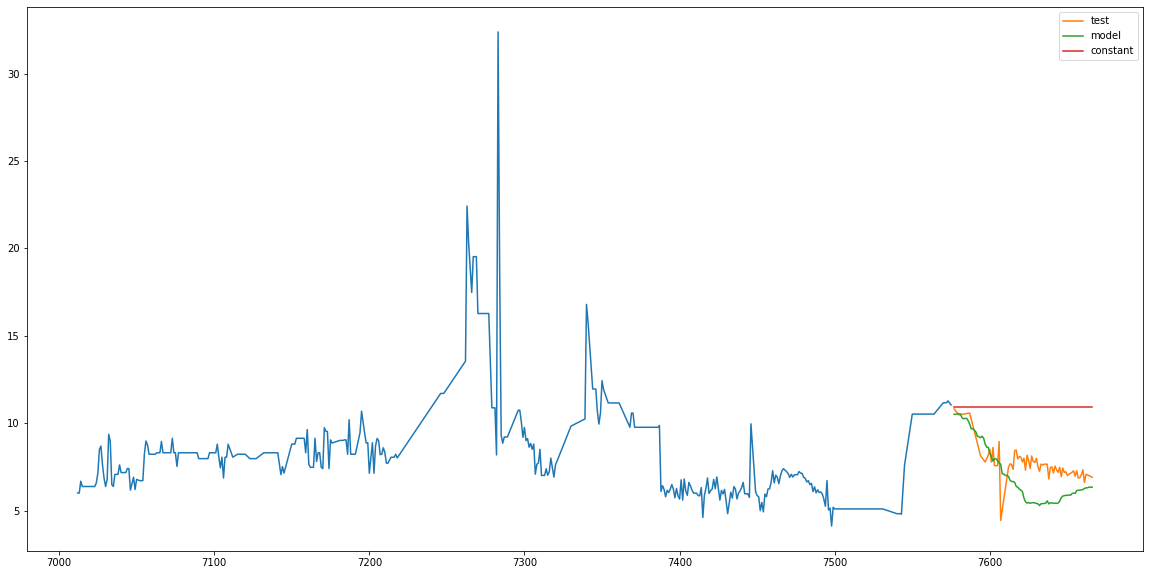

In [155]:
predict(11)

In [103]:
def main(data, forecast_horizon = 90):
    wells = data['Номер скважины'].unique()
    
    date_range = pd.date_range(start='1992-04-11', freq='1D', periods=forecast_horizon)
    all_forecasts = []
    for well in wells:
        print(f'Processing well № {well}')
        well_n = data.query(f'`Номер скважины` == {well}')
       # X,y, datetime,reference = data_preprocessing(well_n)
        
       # optimized_regressor = train_model(X,y)
        X['datetime'] = datetime.values
        last_date = well_n[well_n.datetime == '1992-04-11']
        last_date_pred = X.loc[(X.datetime == last_date.datetime.values[0]) & (X['Номер скважины'] == well)]
        last_date_pred_f = last_date_pred.drop(columns='datetime').iloc[0]
        
        #make prediction
        predictions = []
        for i in range(0,forecast_horizon):
            last_date_pred_f['Прогноз_вперед'] =  i
            pred = (optimized_regressor.predict(last_date_pred_f))
            
            if i > 40:
                pred = last_date_pred_f['Дебит нефти']
  
            predictions.append(pred)
            
        plt.plot(predictions)
        plt.show()
        forecast_df = pd.DataFrame({'datetime': date_range, 'forecast': predictions})
        forecast_df['Номер скважины'] = [well] * len(predictions)
        all_forecasts.append(forecast_df)
            
    all_forecasts = pd.concat(all_forecasts)
    print(f'Completed data processing. Forecast shape: {all_forecasts.shape}')
    print(f'Number of unique wells: {len(all_forecasts["Номер скважины"].unique())}')

    all_forecasts.to_csv('catboost_forecast.csv', index=False, encoding="utf-8")
    print('Saved forecast to "baseline_forecast.csv"')

Processing well № 0


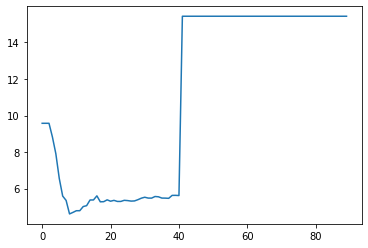

Processing well № 1


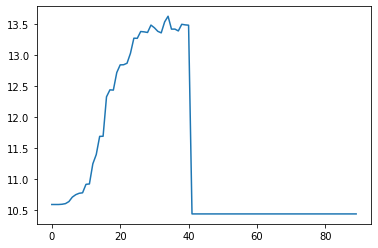

Processing well № 2


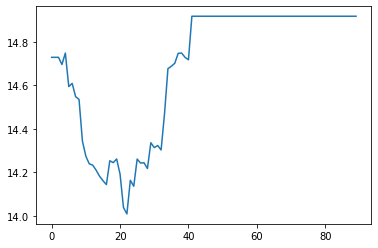

Processing well № 3


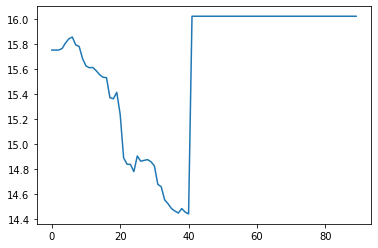

Processing well № 4


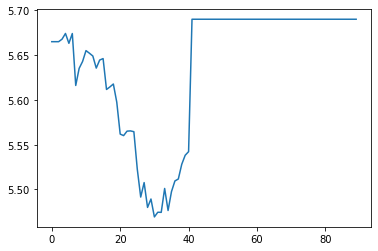

Processing well № 5


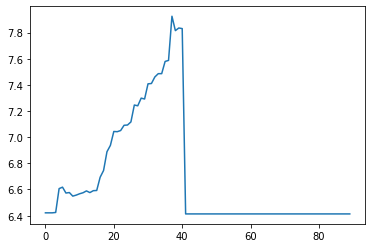

Processing well № 6


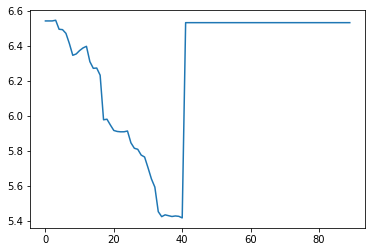

Processing well № 7


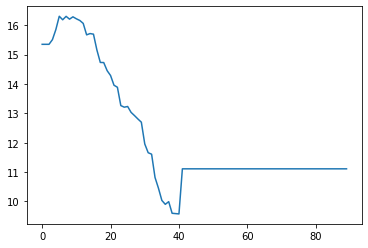

Processing well № 8


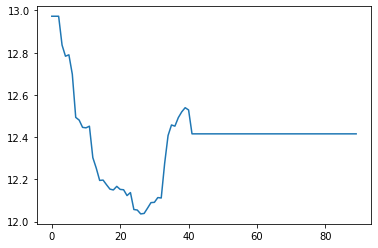

Processing well № 9


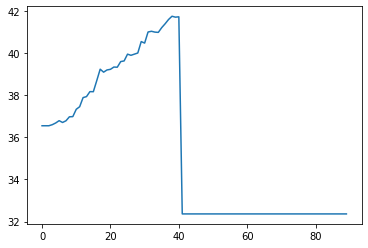

Processing well № 10


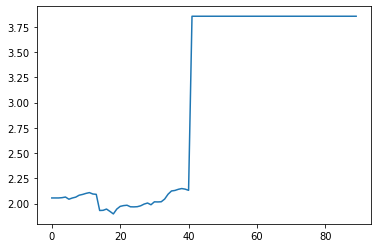

Processing well № 11


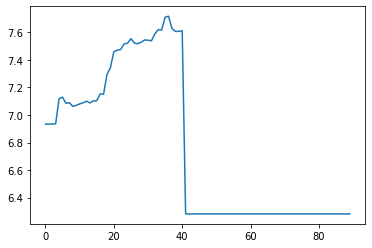

Processing well № 12


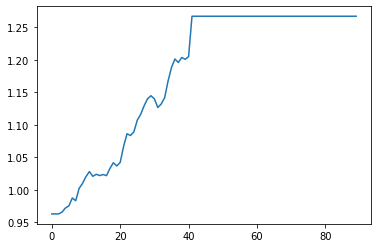

Processing well № 13


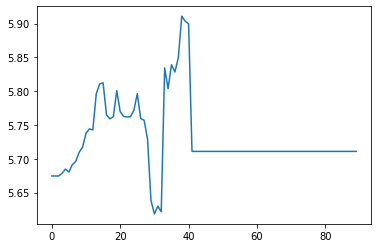

Processing well № 14


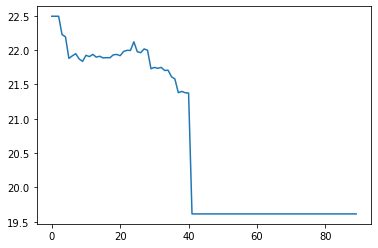

Processing well № 15


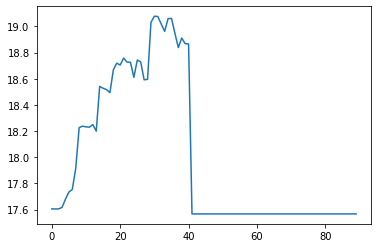

Processing well № 16


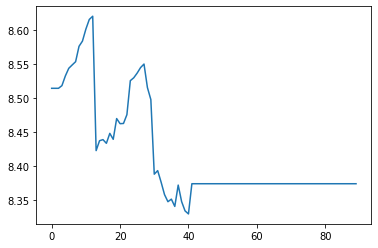

Processing well № 17


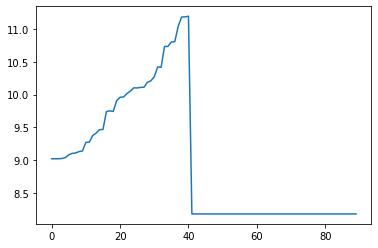

Processing well № 18


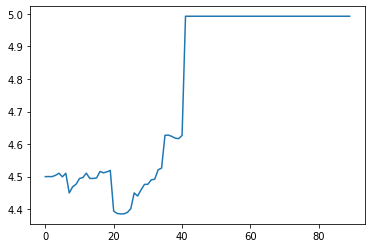

Processing well № 19


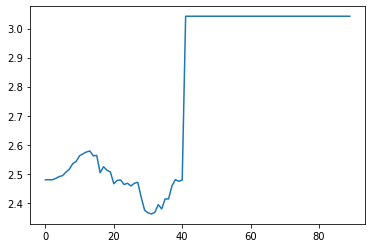

Processing well № 20


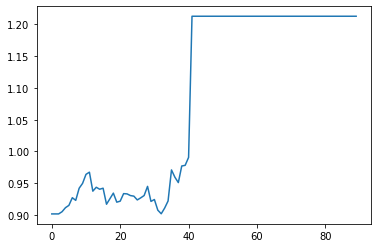

Processing well № 21


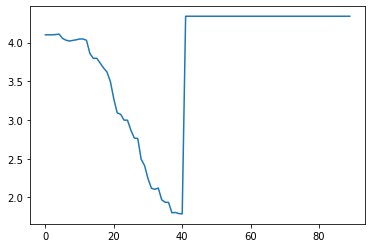

Processing well № 22


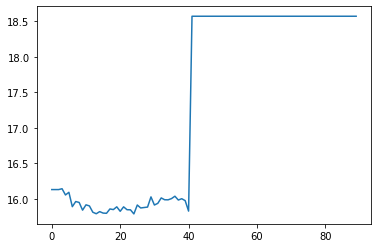

Processing well № 23


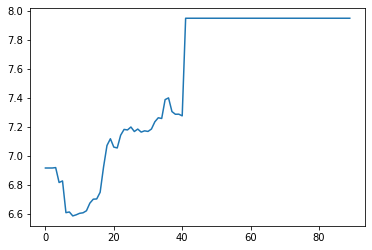

Processing well № 24


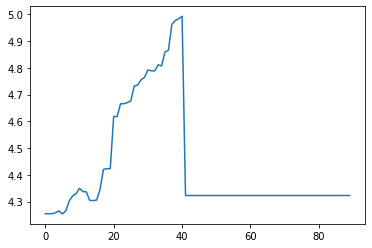

Processing well № 25


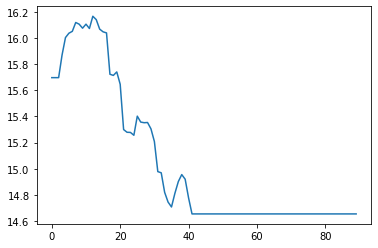

Processing well № 26


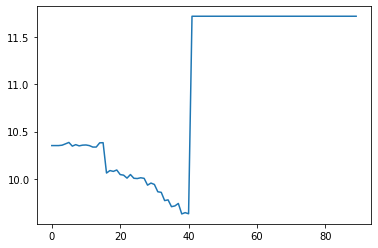

Processing well № 27


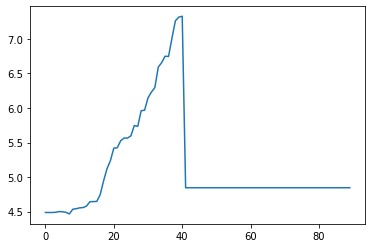

Processing well № 28


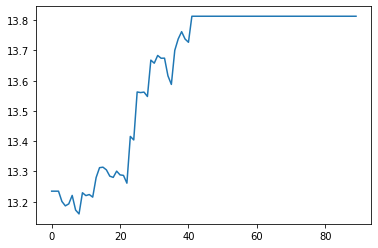

Processing well № 29


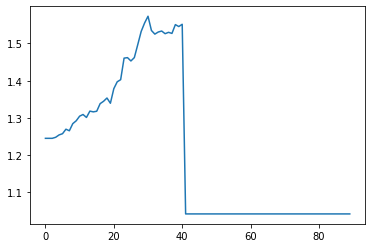

Processing well № 30


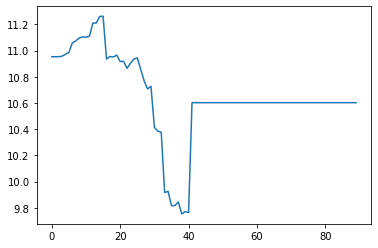

Processing well № 31


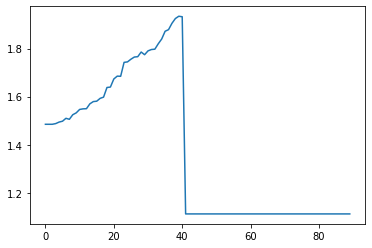

Processing well № 32


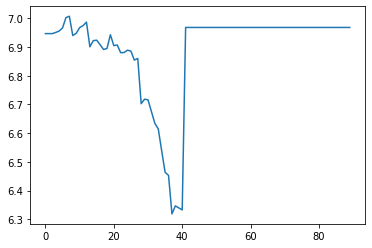

Processing well № 33


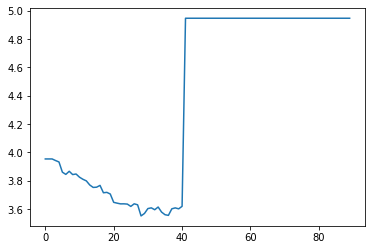

Processing well № 34


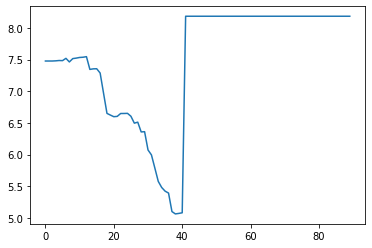

Processing well № 35


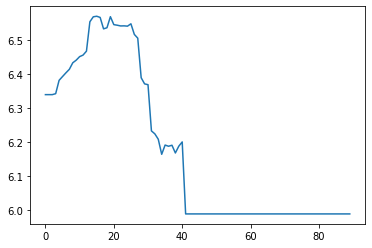

Processing well № 36


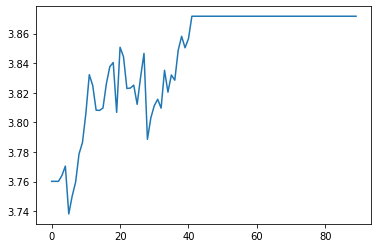

Processing well № 37


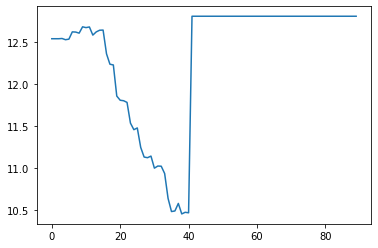

Processing well № 38


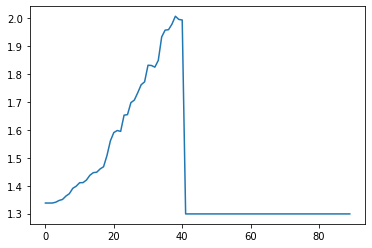

Processing well № 39


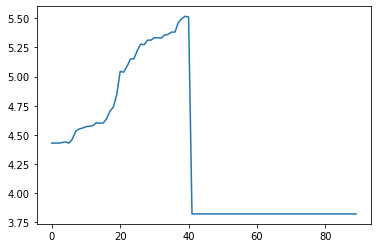

Processing well № 40


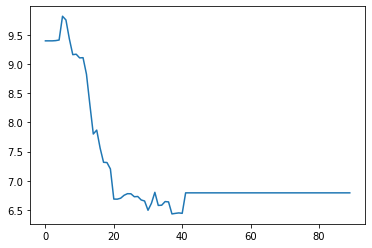

Processing well № 41


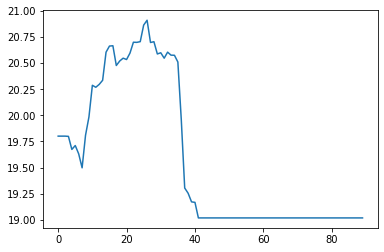

Processing well № 42


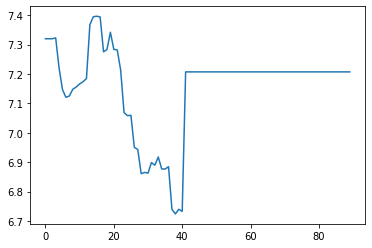

Processing well № 43


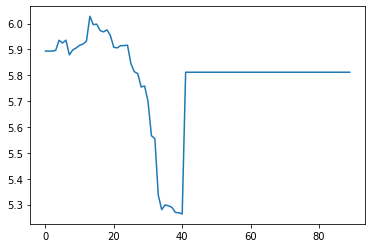

Processing well № 44


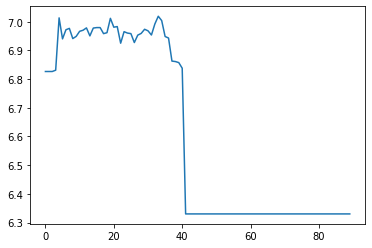

Processing well № 45


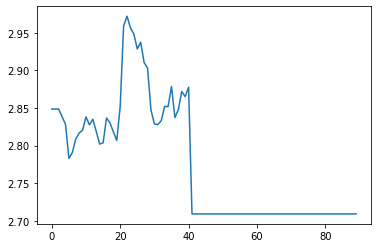

Processing well № 46


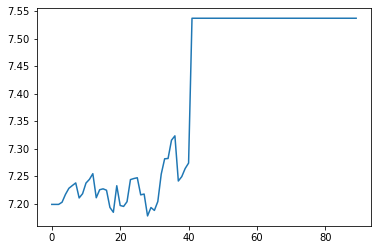

Processing well № 47


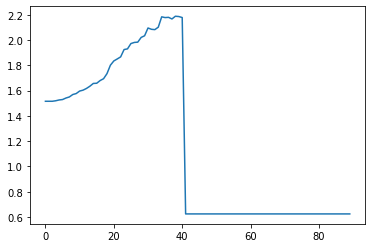

Processing well № 48


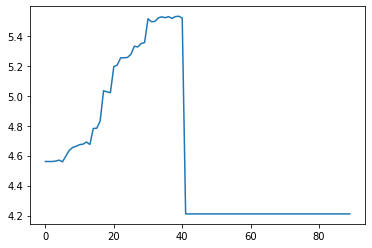

Processing well № 49


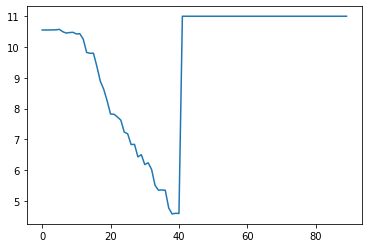

Processing well № 50


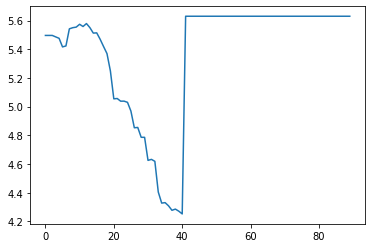

Processing well № 51


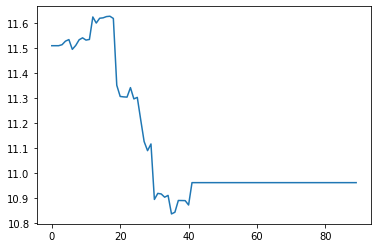

Processing well № 52


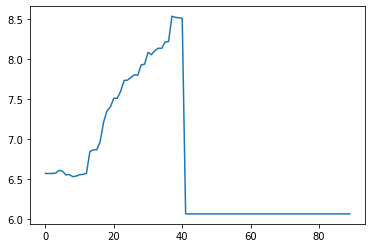

Processing well № 53


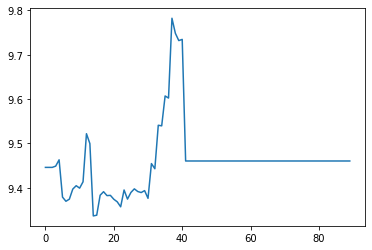

Processing well № 54


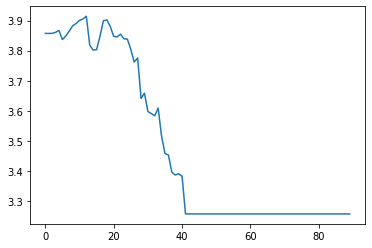

Processing well № 55


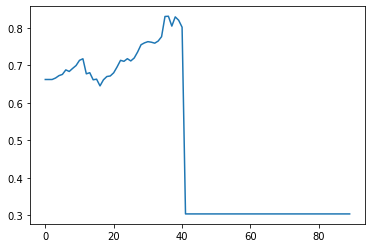

Processing well № 56


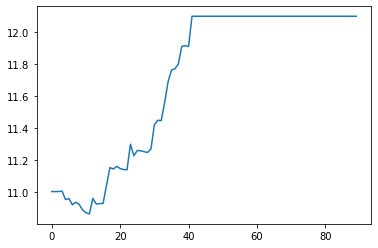

Processing well № 57


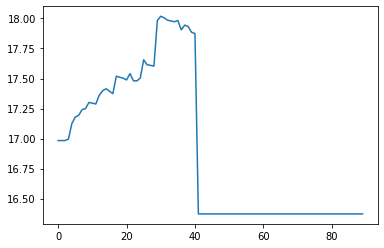

Processing well № 58


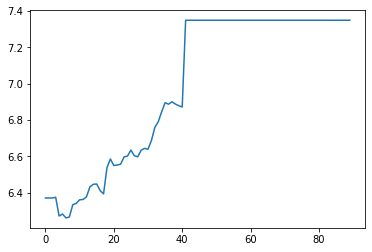

Processing well № 59


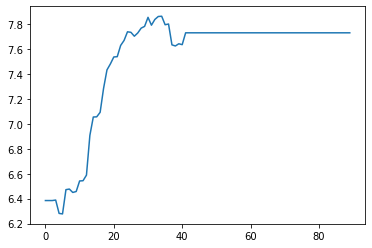

Processing well № 60


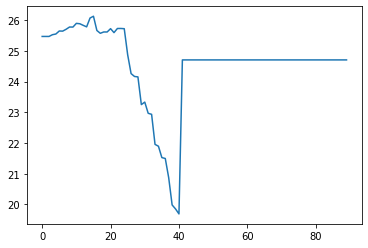

Processing well № 61


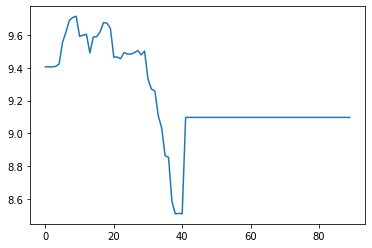

Processing well № 62


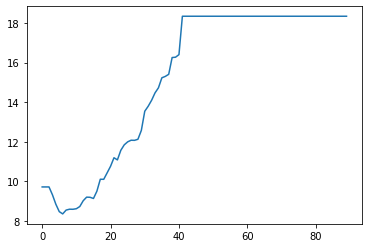

Processing well № 63


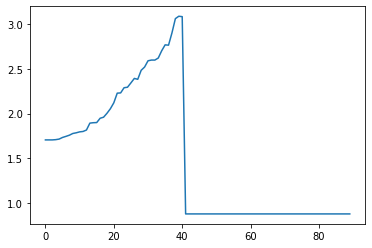

Processing well № 64


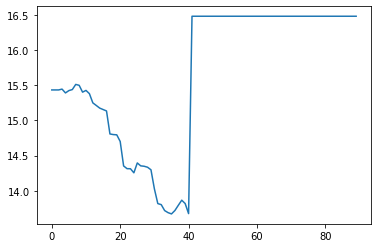

Processing well № 65


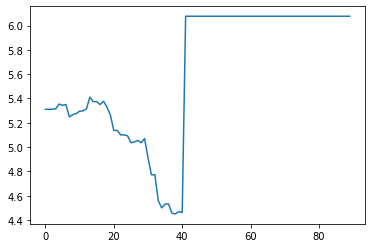

Processing well № 66


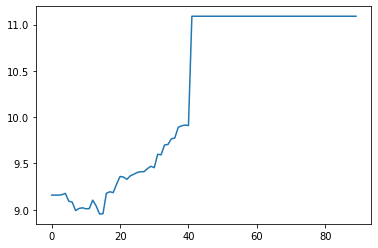

Processing well № 67


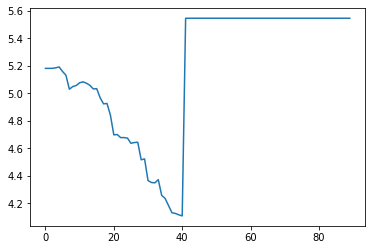

Processing well № 68


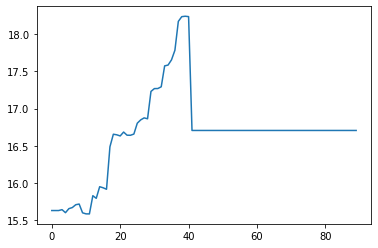

Processing well № 69


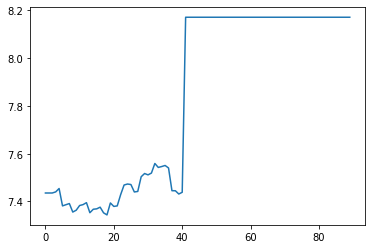

Processing well № 70


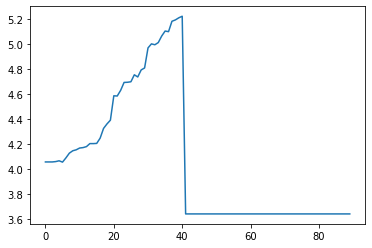

Processing well № 71


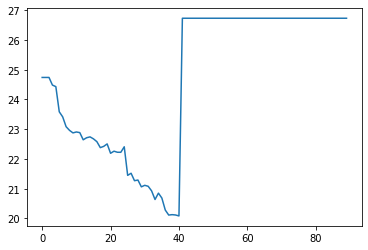

Processing well № 72


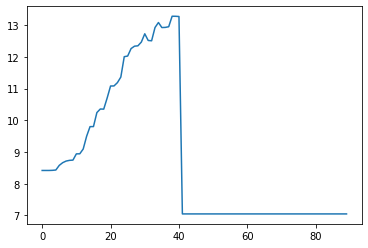

Processing well № 73


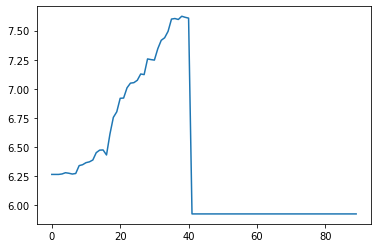

Processing well № 74


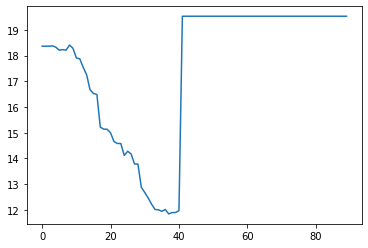

Processing well № 75


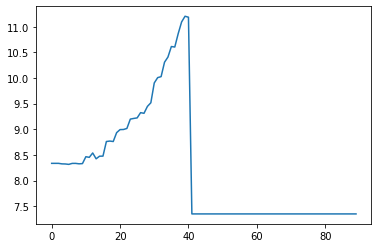

Processing well № 76


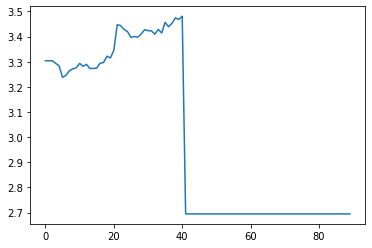

Processing well № 77


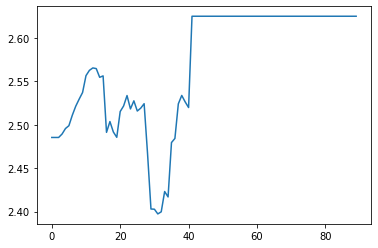

Processing well № 78


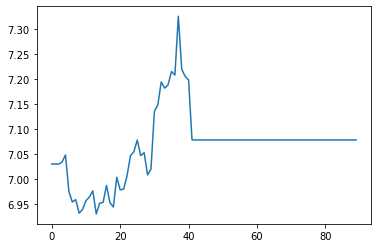

Processing well № 79


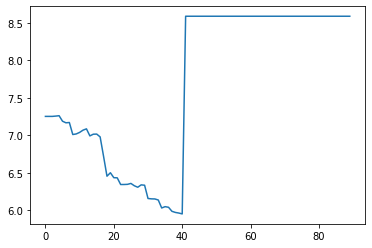

Processing well № 80


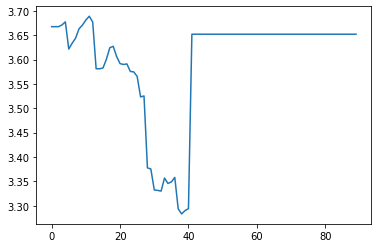

Processing well № 81


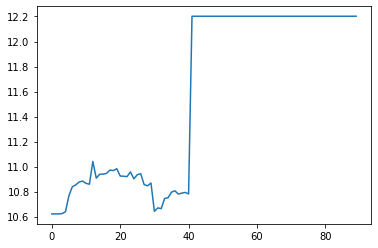

Processing well № 82


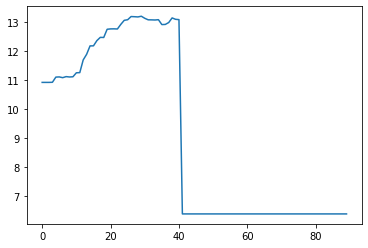

Processing well № 83


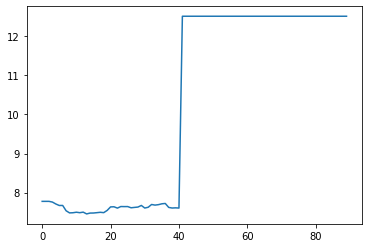

Processing well № 84


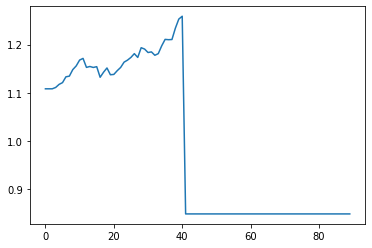

Processing well № 85


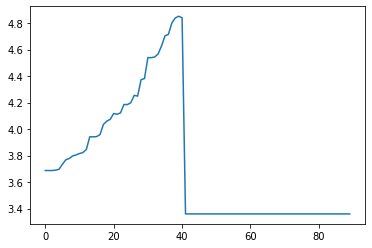

Processing well № 86


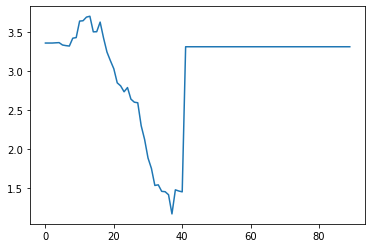

Processing well № 87


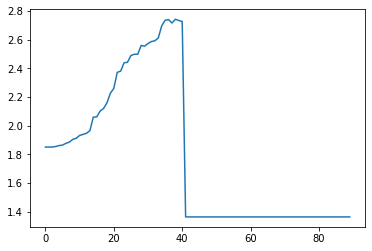

Processing well № 88


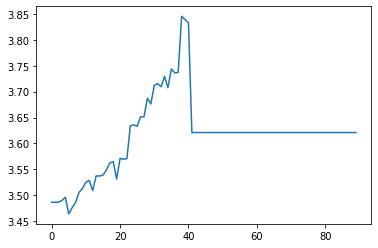

Processing well № 89


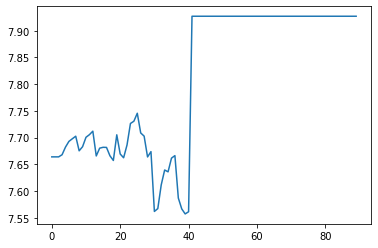

Processing well № 90


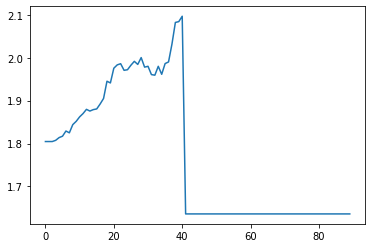

Processing well № 91


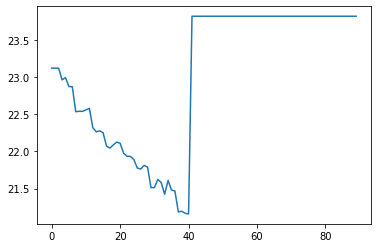

Processing well № 92


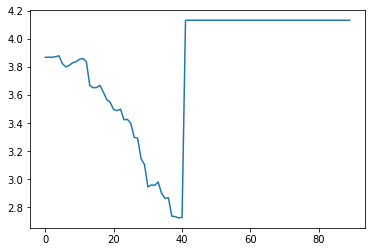

Processing well № 93


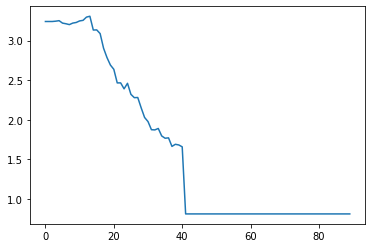

Processing well № 94


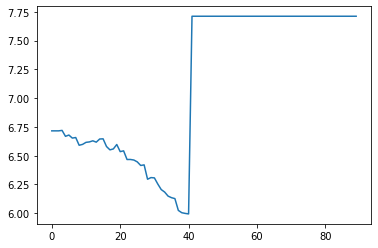

Processing well № 95


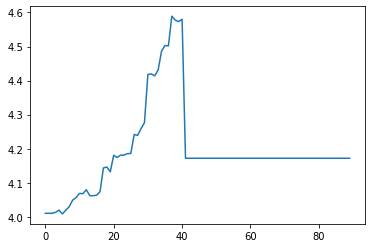

Processing well № 96


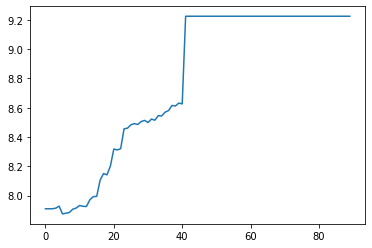

Processing well № 97


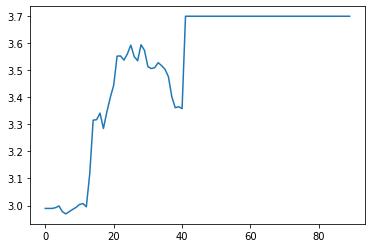

Processing well № 98


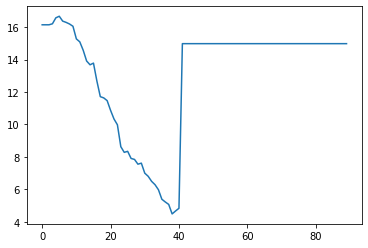

Processing well № 99


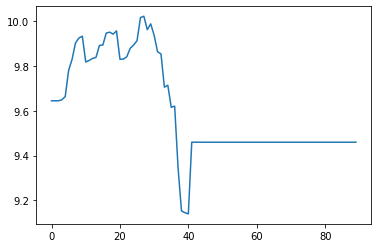

Processing well № 100


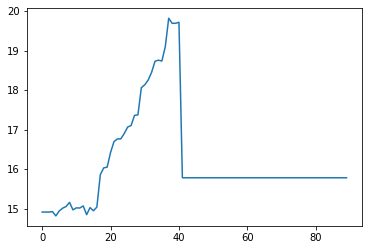

Processing well № 101


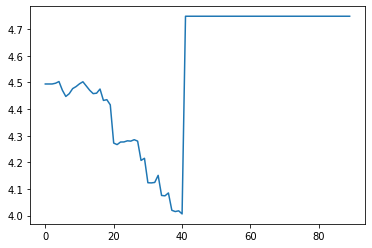

Processing well № 102


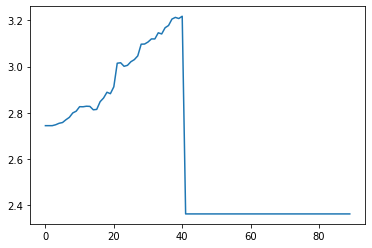

Processing well № 103


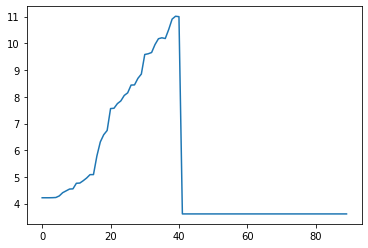

Processing well № 104


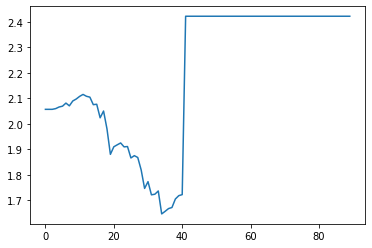

Processing well № 105


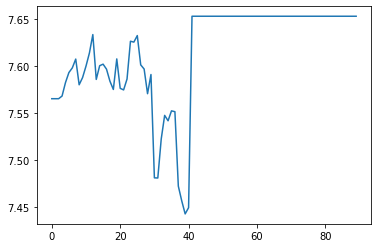

Completed data processing. Forecast shape: (9540, 3)
Number of unique wells: 106
Saved forecast to "baseline_forecast.csv"


In [104]:
main(data)